In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from Bio.Phylo._io import parse
from Bio.Phylo.BaseTree import Tree as BioTree, Clade as BioClade
from tqdm import tqdm
from random import sample

In [68]:
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [290]:
# TREE_DIRECTORY = Path("../../data/beast")
TREE_DIRECTORY = Path("/Users/tobiaochsner/Documents/Thesis/DSconfig7/DS4_HKY/config7/run1")
NUM_TAXA = 10

In [291]:
# load trees

all_trees: list[BioTree] = []
for file in tqdm(list(TREE_DIRECTORY.glob("*.trees"))[:5]): 
    all_trees += parse(file, "nexus")

trees = sample(all_trees, 50000)

100%|██████████| 1/1 [02:10<00:00, 130.75s/it]


In [293]:
taxa_names = [
    terminal.name for terminal in trees[0].get_terminals()
]

In [294]:
from types import UnionType
from typing import Any, Optional
from dataclasses import dataclass

@dataclass
class Clade:
    bitstring: int
    height: float | int
    level: int
    left_clade: Optional["Clade"] = None
    right_clade: Optional["Clade"] = None

    def __str__(self) -> str:
        return "{0:010b}".format(self.bitstring)
    
    @property
    def is_leaf(self):
        return not self.left_clade and not self.right_clade

@dataclass
class CladeSet:
    bitstring: tuple[int, int]
    height: float | int
    left_clade: Clade
    right_clade: Clade
    level: int

    def __str__(self) -> str:
        return "{0:010b}||{1:010b}".format(*self.bitstring)

In [296]:
# intialize clades and cladesets

from random import random


all_clades: list[Clade] = []
all_clade_sets: list[CladeSet] = []

clade_sets_per_tree: list[list[CladeSet]] = [[] for tree in trees]


def process_tree(bio_clade: BioClade, tree_index: int, height: float = 0, level: int = 0) -> Clade:
    if bio_clade.is_terminal():
        clade_bitstring = 1
        clade_bitstring = clade_bitstring << taxa_names.index(bio_clade.name)
        clade = Clade(
            bitstring=clade_bitstring,
            height=height,
            level=level
        )
        all_clades.append(clade)
        return clade

    left_clade = process_tree(bio_clade.clades[0], tree_index, height + (bio_clade.clades[0].branch_length or 0), level + 1)
    right_clade = process_tree(bio_clade.clades[1], tree_index, height + (bio_clade.clades[1].branch_length or 0), level + 1)

    clade_bitstring = left_clade.bitstring | right_clade.bitstring

    clade = Clade(
        bitstring=clade_bitstring,
        height=height,
        left_clade=left_clade,
        right_clade=right_clade,
        level=level
    )
    all_clades.append(clade)

    clade_set = CladeSet(
        bitstring=(left_clade.bitstring, right_clade.bitstring),
        height=height,
        left_clade=left_clade,
        right_clade=right_clade,
        level=level
    )
    all_clade_sets.append(clade_set)
    clade_sets_per_tree[tree_index].append(clade_set)

    return clade


for i, tree in tqdm(list(enumerate(trees))):
    process_tree(tree.root, i)
    break

  0%|          | 0/50000 [00:00<?, ?it/s]


In [197]:
# construct dataframe with the clade heights
df_dict = {
    "clade": [],
    "height": [],
}

for clade in all_clades:
    df_dict["clade"].append(str(clade)) 
    df_dict["height"].append(clade.height)

df_heights = pd.DataFrame(df_dict)

df_heights.describe()

,height
count,950000.000000
mean,0.052074
std,0.026219
min,0.000000
25%,0.031905
50%,0.057602
75%,0.071326
max,0.164074


In [198]:
%%script true

grid = sns.FacetGrid(df_heights, col="clade", col_wrap=8, height=2, xlim=(0, 0.35))
grid.map(sns.histplot, "height", kde=True, stat="density")

In [199]:
# construct dataframe with the clade set heights
df_cladeset_dict = {
    "cladeset": [],
    "height": [],
}

for clade_set in all_clade_sets:
    df_cladeset_dict["cladeset"].append(str(clade_set))
    df_cladeset_dict["height"].append(clade_set.height)

df_cladesets = pd.DataFrame(df_cladeset_dict)

df_cladesets.describe()

,height
count,450000.000000
mean,0.039182
std,0.026901
min,0.000000
25%,0.016349
50%,0.038687
75%,0.061165
max,0.161485


In [200]:
%%script true

grid = sns.FacetGrid(df_cladesets, col="cladeset", col_wrap=8, height=2, xlim=(0, 0.35))
grid.map(sns.histplot, "height", kde=True, stat="density")

In [204]:
# construct dataframe with the branch lengths of clades
df_dict = {
    "clade": [],
    "left_branch": [],
    "right_branch": [],
    "level": [],
}

for clade in all_clades:
    if not clade.left_clade or not clade.right_clade:
        continue

    df_dict["clade"].append(str(clade)) 
    df_dict["left_branch"].append(clade.height - clade.left_clade.height)
    df_dict["right_branch"].append(clade.height - clade.right_clade.height)
    df_dict["level"].append(clade.level)

df_branches = pd.DataFrame(df_dict)

df_branches.describe()

,left_branch,right_branch,level
count,4.500000e+05,4.500000e+05,450000.000000
mean,-1.394569e-02,-1.762421e-02,2.199087
std,1.373613e-02,1.799555e-02,1.317034
min,-1.221745e-01,-1.305655e-01,0.000000
25%,-2.021707e-02,-2.537664e-02,1.000000
50%,-9.011541e-03,-1.043270e-02,2.000000
75%,-3.809595e-03,-4.404574e-03,3.000000
max,-1.154600e-08,-8.465992e-08,6.000000


<Axes: xlabel='left_branch', ylabel='right_branch'>

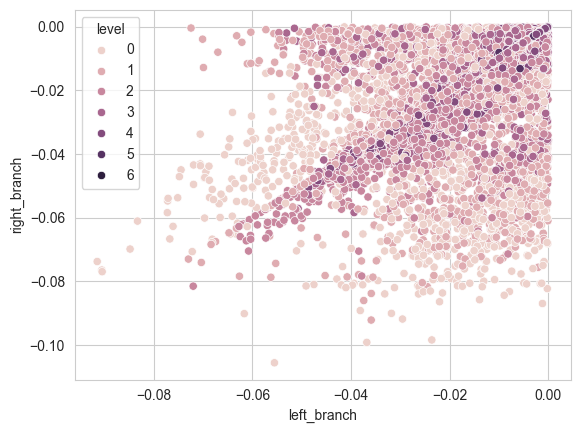

In [205]:
sns.scatterplot(data=df_branches.sample(10_000), x="left_branch", y="right_branch", hue="level")

In [206]:
# construct dataframe with the branch lengths of clade splits
df_dict = {
    "cladesplit": [],
    "left_branch": [],
    "right_branch": [],
    "min_branch": [],
    "max_branch": [],
    "extended_branch": [],
    "ratio_left": [],
    "ratio_right": [],
    "level": [],
}

for clade_split in tqdm(all_clade_sets):
    df_dict["cladesplit"].append(str(clade_split))
    
    left = clade_split.left_clade.height - clade_split.height
    right = clade_split.right_clade.height - clade_split.height
    
    df_dict["left_branch"].append(left)
    df_dict["right_branch"].append(right)
    
    df_dict["min_branch"].append(min(left, right))
    df_dict["max_branch"].append(max(left, right))

    df_dict["extended_branch"].append(max(left, right) - min(left, right))

    df_dict["ratio_left"].append(left / left)
    df_dict["ratio_right"].append(right / left)
    
    df_dict["level"].append(clade_split.level)

df_branches_splits = pd.DataFrame(df_dict)

df_branches_splits.describe()

100%|██████████| 450000/450000 [00:00<00:00, 720225.84it/s]


,left_branch,right_branch,min_branch,max_branch,extended_branch,ratio_left,ratio_right,level
count,4.500000e+05,4.500000e+05,4.500000e+05,4.500000e+05,450000.000000,450000.0,450000.000000,450000.000000
mean,1.394569e-02,1.762421e-02,1.126820e-02,2.030169e-02,0.009033,1.0,9.323959,2.199087
std,1.373613e-02,1.799555e-02,1.176361e-02,1.844187e-02,0.014020,0.0,1248.266759,1.317034
min,1.154600e-08,8.465992e-08,1.154600e-08,8.465992e-08,0.000000,1.0,0.000009,0.000000
25%,3.809595e-03,4.404574e-03,3.041955e-03,5.933766e-03,0.000000,1.0,1.000000,1.000000
50%,9.011541e-03,1.043270e-02,6.910361e-03,1.381056e-02,0.002803,1.0,1.000000,2.000000
75%,2.021707e-02,2.537664e-02,1.560653e-02,3.059751e-02,0.011138,1.0,1.568761,3.000000
max,1.221745e-01,1.305655e-01,1.119977e-01,1.305655e-01,0.117432,1.0,766006.071401,6.000000


Text(0.5, 1.0, 'Branch lengths per split (Yule-10)')

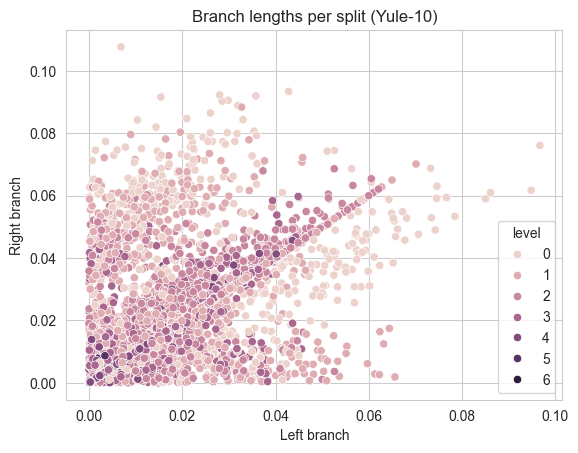

In [208]:
sns.scatterplot(data=df_branches_splits.sample(5000), x="left_branch", y="right_branch", hue="level")
plt.xlabel("Left branch")
plt.ylabel("Right branch")
plt.title("Branch lengths per split (Yule-10)")

Text(0.5, 1.0, 'Branch length correlation per level (Yule-10)')

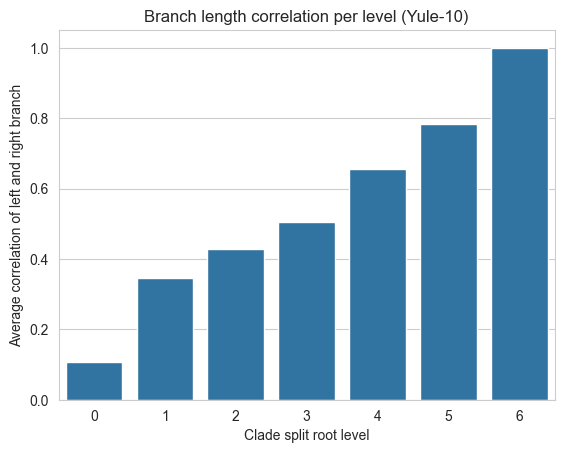

In [209]:
avg_correlation_per_level = df_branches_splits.groupby("level").apply(
    lambda x: x.groupby("cladesplit")
    .apply(lambda y: y["left_branch"].corr(y["right_branch"]))
    .mean()
)
sns.barplot(data=avg_correlation_per_level)

plt.ylabel("Average correlation of left and right branch")
plt.xlabel("Clade split root level")

plt.title("Branch length correlation per level (Yule-10)")

In [189]:
mean_correlations_dict = {
    "Variable": [
        "b1, b2",
        "min(b1, b2), max(b1, b2)",
        "min(b1, b2), max(b1, b2) - min(b1, b2)",
    ],
    "Correlation": [
        df_branches_splits.groupby('cladesplit').apply(lambda x: x['left_branch'].corr(x['right_branch'])).mean(),
        df_branches_splits.groupby('cladesplit').apply(lambda x: x['min_branch'].corr(x['max_branch'])).mean(),
        df_branches_splits.groupby('cladesplit').apply(lambda x: x['min_branch'].corr(x['extended_branch'])).mean()
    ]
}
mean_correlations_df = pd.DataFrame(mean_correlations_dict)

Text(0.5, 1.0, 'Correlation of different variables (Yule-10)')

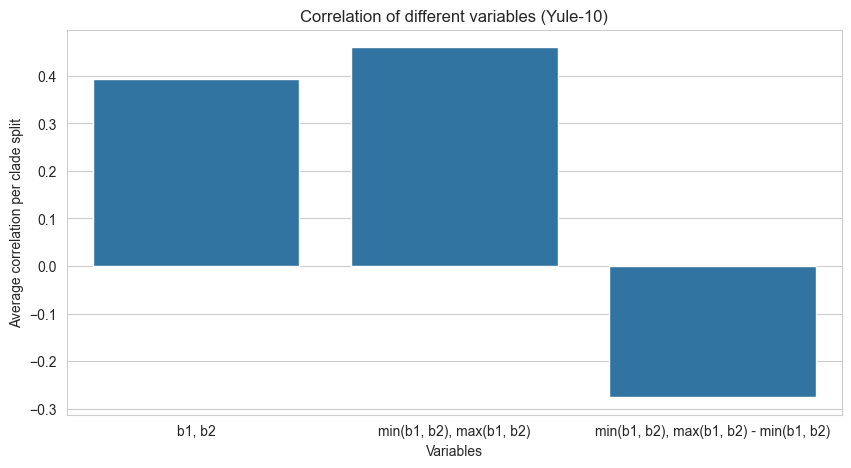

In [211]:
plt.figure(figsize=(10, 5))
sns.barplot(data=mean_correlations_dict, x="Variable", y="Correlation")

plt.ylabel("Average correlation per clade split")
plt.xlabel("Variables")
plt.title("Correlation of different variables (Yule-10)")